# Lesson 4 - Data Generation
- 이번 실습자료에서는 파이토치 모델에 이미지를 입력값으로 주기위해 전처리를 하는 방법을 배웁니다.
- 파이토치는 torch.utils.data에 있는 Dataset, DataLoader 클래스가 이 작업을 간편하게 해줍니다.
## 0. Libraries & Configurations
- 시각화에 필요한 라이브러리와 데이터 경로를 설정합니다.

In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import time

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Configurations
data_dir = './input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [3]:
df = pd.read_csv(df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


## 1. Image Statistics

- 2강 실습자료에서 사용되었던 데이터셋의 RGB 평균, 표준편차를 구하는 함수를 이용하여 그에 대해 계산합니다.

In [4]:
def get_ext(img_dir, img_id):
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [5]:
def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [6]:
img_info = get_img_stats(img_dir, df.path.values)

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

100%|██████████| 2700/2700 [05:50<00:00,  7.70it/s]

RGB Mean: [0.56019358 0.52410121 0.501457  ]
RGB Standard Deviation: [0.23318603 0.24300033 0.24567522]


## 2. Dataset
- 이 부분에서는 Dataset을 정의하는 방법을 간단하게 배웁니다.

## 2.1 Augmentation Function
- 3강에서 배운 Augmentation 함수를 정의합니다.
- mean, std는 임의로 설정하였으나 파트 1에서 계산한 값을 입력해도 괜찮습니다.

In [7]:
mean, std = (0.56019358, 0.52410121, 0.501457), (0.23318603, 0.24300033, 0.24567522)

### 2.1.1 Torchvision Style Augmentation Function
- Torchvision에서 제공되는 transforms를 이용한 Augmentation 함수입니다.
- 이를 사용하여 Dataset을 정의하여도 괜찮지만, 이번 실습자료에서는 강의에서 배웠던 Albumentation을 활용해봅시다.

In [8]:
''' Torchvision-Style Transforms
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur, RandomRotation, ColorJitter


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


def get_transforms(need=('train', 'val'), img_size=(512, 384)):
    transformations = {}
    if 'train' in need:
        transformations['train'] = transforms.Compose([
            Resize((img_size[0], img_size[1])),
            RandomRotation([-8, +8]),
            GaussianBlur(51, (0.1, 2.0)),
            ColorJitter(brightness=0.5, saturation=0.5, hue=0.5),  # todo : param
            ToTensor(),
            Normalize(mean=mean, std=std),
            AddGaussianNoise(0., 1.)
        ])
    if 'val' in need:
        transformations['val'] = transforms.Compose([
            Resize((img_size[0], img_size[1])),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])
    return transformations
'''

" Torchvision-Style Transforms\nfrom torchvision import transforms\nfrom torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur, RandomRotation, ColorJitter\n\n\nclass AddGaussianNoise(object):\n    def __init__(self, mean=0., std=1.):\n        self.std = std\n        self.mean = mean\n\n    def __call__(self, tensor):\n        return tensor + torch.randn(tensor.size()) * self.std + self.mean\n\n    def __repr__(self):\n        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)\n\n\ndef get_transforms(need=('train', 'val'), img_size=(512, 384)):\n    transformations = {}\n    if 'train' in need:\n        transformations['train'] = transforms.Compose([\n            Resize((img_size[0], img_size[1])),\n            RandomRotation([-8, +8]),\n            GaussianBlur(51, (0.1, 2.0)),\n            ColorJitter(brightness=0.5, saturation=0.5, hue=0.5),  # todo : param\n            ToTensor(),\n            Normalize(mean=mean, std=std),\n       

### 2.1.2 Albumentation Style Augmentation Function
- Albumentation은 numpy 형식으로 이미지를 받아 데이터를 변형시킵니다.
- opencv 기반으로 빠르고, 다양한 Augmentation 방법이 제공되는 점에서 장점이 있습니다.

In [9]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.560, 0.524, 0.501), std=(0.233, 0.243, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            #CenterCrop(224, 224, p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            #CenterCrop(224, 224, p=1.0),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

### 2.2 Define Dataset

- 여기에서는 이미지와 레이블을 출력하는 Dataset 클래스를 정의합니다.
- 레이블은 마스크 여부, 성별, 나이로 결정이 됩니다.
- 레이블은 3(마스크 착용, 미착용, 잘못착용) * 2(남성, 여성) * 3(30세 미만, 30세-60세, 60세 이상) 으로 총 18개가 존재합니다.

<img src="https://i.ibb.co/BfCrm1Q/class.png" width="600">

In [10]:
### 마스크 여부, 성별, 나이를 mapping할 클래스를 생성합니다.

class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2

class GenderLabels:
    male = 0
    female = 1

class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 60 else 2

In [11]:
class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1.jpg": MaskLabels.mask,
        "mask2.jpg": MaskLabels.mask,
        "mask3.jpg": MaskLabels.mask,
        "mask4.jpg": MaskLabels.mask,
        "mask5.jpg": MaskLabels.mask,
        "incorrect_mask.jpg": MaskLabels.incorrect,
        "normal.jpg": MaskLabels.normal
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            for file_name, label in self._file_names.items():
                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.mask_labels.append(label)

                    id, gender, race, age = profile.split("_")
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)

                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

In [12]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
transform = get_transforms(mean=mean, std=std)

dataset = MaskBaseDataset(
    img_dir=img_dir
)

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

## 3. DataLoader
- 정의한 Dataset을 바탕으로 DataLoader을 생성합니다.
- Dataset은 이미지 한장을 주는 모듈이라면, DataLoader은 여러 이미지를 batch_size만큼 묶어 전달해줍니다.

In [13]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

## 4.  Visualize Processed Data
- 파트 4에선 정의한 DataLoader을 이용하여 데이터가 어떻게 전처리 되었는지 시각화하여 확인합니다.

In [14]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([12, 3, 512, 384])
labels shape: torch.Size([12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


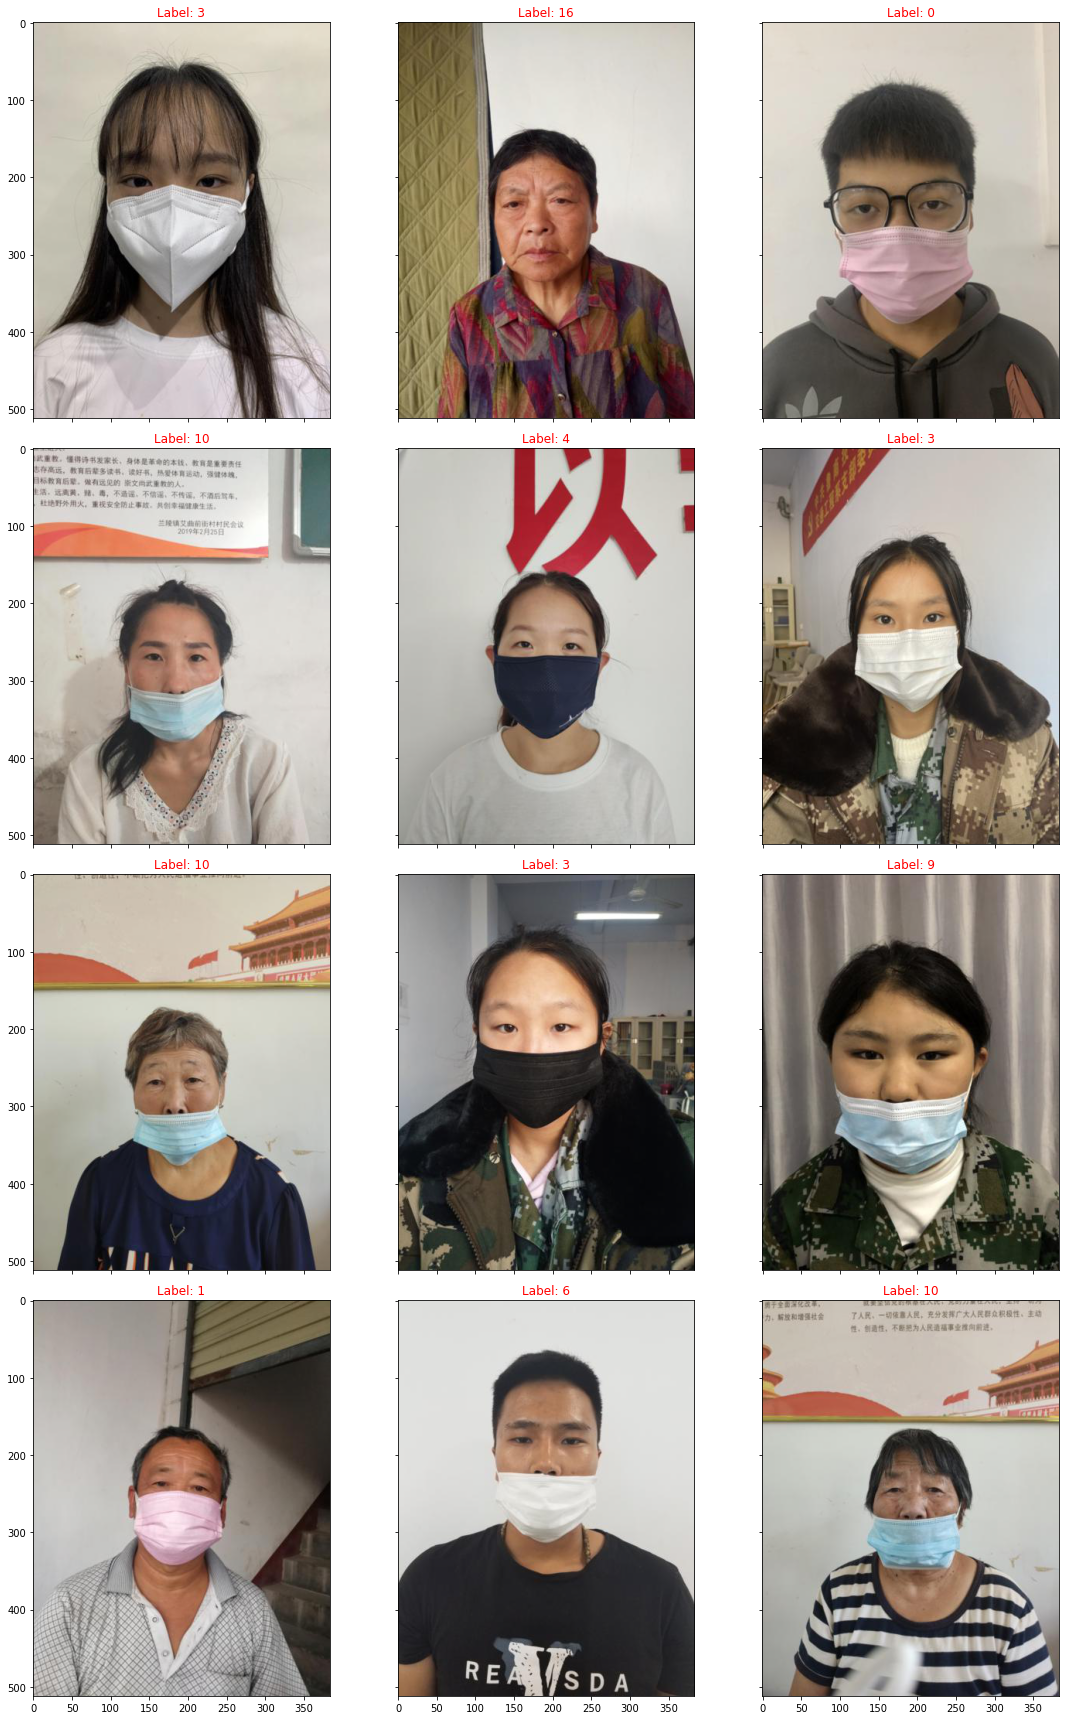

In [15]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize 해주어야합니다.
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()

## 1. Get Pre-Trained Model

In [16]:
!pip install timm
import timm

m = timm.create_model('tf_efficientnet_b7_ns', pretrained=True)
m.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
        (conv_dw): Conv2d

In [17]:
type(m)

timm.models.efficientnet.EfficientNet

In [18]:
import torch.nn as nn
num_classes = 18
model = m
model.classifier = nn.Linear(2560, num_classes)
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
        (conv_dw): Conv2d

In [19]:
import torch.nn.init as init

def initialize_weights(model):
    """
    Initialize all weights using xavier uniform. 
    For more weight initialization methods, check https://pytorch.org/docs/stable/nn.init.html
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

In [20]:
# Initialize only classifier part
initialize_weights(model.classifier)

# 2. Train

In [21]:
import random
import os, sys
from importlib import import_module

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

sys.path.append(os.path.abspath('..'))
#from dataset import MaskBaseDataset
#from model import *

sys.path.append('../')
#from dataset import MaskMultiClassDataset

def seed_everything(seed):
    """
    동일한 조건으로 학습을 할 때, 동일한 결과를 얻기 위해 seed를 고정시킵니다.
    
    Args:
        seed: seed 정수값
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(42)

In [22]:
# -- parameters
img_root = './input/data/train/images'  # 학습 이미지 폴더의 경로
label_path = './input/data/train/train.csv'  # 학습 메타파일의 경로

model_name = "tf_efficientnet_b7_ns"  # 모델 이름
use_pretrained = True  # pretrained-model의 사용 여부
freeze_backbone = False  # classifier head 이 외 부분을 업데이트되지 않게 할 것인지 여부

val_split = 0.1  # validation dataset의 비율
batch_size = 6
num_workers = 4
num_classes = 18

num_epochs = 6  # 학습할 epoch의 수
lr = 1e-4
lr_decay_step = 10

train_log_interval = 40  # logging할 iteration의 주기
name = "tf_efficientnet_b7_ns"  # 결과를 저장하는 폴더의 이름

# -- settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [23]:
# -- Cross Entropy Loss
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [24]:
criterion = CrossEntropyLoss()

In [25]:
# -- Adam optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-4)

In [26]:
# -- scheduler: StepLR
# 지정된 step마다 learning rate를 감소시킵니다.
scheduler = StepLR(optimizer, lr_decay_step, gamma=0.5)

In [27]:
# -- scheduler: ReduceLROnPlateau
# 성능이 향상되지 않을 때 learning rate를 줄입니다. patience=10은 10회 동안 성능 향상이 없을 경우입니다.
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

In [28]:
# -- scheduler: CosineAnnealingLR
# CosineAnnealing은 learning rate를 cosine 그래프처럼 변화시킵니다.
scheduler = CosineAnnealingLR(optimizer, T_max=2, eta_min=0.)

In [29]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
transform = get_transforms() # mean & std 이미 정의
dataset = MaskBaseDataset(
    img_dir=img_root
)

# train dataset과 validation dataset을 9:1 비율로 나눕니다.
n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=6,
    num_workers=4,
    shuffle=True,
    pin_memory=use_cuda,
    drop_last=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=6,
    num_workers=4,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True
)

### 5.1 Callback - Checkpoint, Early Stopping

In [30]:
# -- Callback1: Checkpoint - Accuracy가 높아질 때마다 모델을 저장합니다.
# 학습 코드에서 이어집니다.

# -- Callback2: Early Stopping - 성능이 일정 기간동안 향상이 없을 경우 학습을 종료합니다.
patience = 10
counter = 0
# 학습 코드에서 이어집니다.

### 5.2 Training Method - Gradient Accumulation
- Graident Accumulation은 한 iteration에 파라미터를 업데이트시키는게 아니라, gradient를 여러 iteration 동안 쌓아서 업데이트시킵니다. 한 번에 파라미터를 업데이트시키는 건 noise가 있을 수 있으므로, 여러번 쌓아서 한번에 업데이트 시킴으로써 그러한 문제를 방지하기 위함입니다.

In [48]:
# -- Gradient Accumulation
accumulation_steps = 4
# 학습코드에서 이어집니다.

### 5.3 Training Loop

In [49]:
os.makedirs(os.path.join(os.getcwd(), 'results', name), exist_ok=True)

counter = 0
best_val_acc = 0
best_val_loss = np.inf
for epoch in range(4, 4 + num_epochs):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(train_loader):
        inputs, labels = train_batch
        #print(inputs.shape)
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.to(device)

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)

        loss.backward()
        
        # -- Gradient Accumulation
        if (idx+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        if (idx + 1) % train_log_interval == 0:
            train_loss = loss_value / train_log_interval
            train_acc = matches / batch_size / train_log_interval
            current_lr = scheduler.get_last_lr()
            print(
                f"Epoch[{epoch}/{4 + num_epochs}]({idx + 1}/{len(train_loader)}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
            )

            loss_value = 0
            matches = 0

    scheduler.step()

    # val loop
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss = np.sum(val_loss_items) / len(val_loader)
        val_acc = np.sum(val_acc_items) / len(val_dataset)
        
        # Callback1: validation accuracy가 향상될수록 모델을 저장합니다.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_acc > best_val_acc:
            print("New best model for val accuracy! saving the model..")
            torch.save(model.state_dict(), f"results/{name}/{epoch:03}_accuracy_{val_acc:4.2%}.ckpt")
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
        # Callback2: patience 횟수 동안 성능 향상이 없을 경우 학습을 종료시킵니다.
        if counter > patience:
            print("Early Stopping...")
            break
        
        
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )

Epoch[4/10](40/5410) || training loss 0.01629 || training accuracy 99.58% || lr [0.0001]
Epoch[4/10](80/5410) || training loss 0.02004 || training accuracy 99.17% || lr [0.0001]
Epoch[4/10](120/5410) || training loss 0.01535 || training accuracy 100.00% || lr [0.0001]
Epoch[4/10](160/5410) || training loss 0.01295 || training accuracy 99.58% || lr [0.0001]
Epoch[4/10](200/5410) || training loss 0.04314 || training accuracy 98.33% || lr [0.0001]
Epoch[4/10](240/5410) || training loss 0.02319 || training accuracy 98.75% || lr [0.0001]
Epoch[4/10](280/5410) || training loss 0.1007 || training accuracy 97.50% || lr [0.0001]
Epoch[4/10](320/5410) || training loss 0.04597 || training accuracy 97.50% || lr [0.0001]
Epoch[4/10](360/5410) || training loss 0.01739 || training accuracy 99.58% || lr [0.0001]
Epoch[4/10](400/5410) || training loss 0.05124 || training accuracy 98.33% || lr [0.0001]
Epoch[4/10](440/5410) || training loss 0.04981 || training accuracy 98.33% || lr [0.0001]
Epoch[4/10](

KeyboardInterrupt: 

In [34]:
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [35]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [38]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.56019358, 0.52410121, 0.501457), std=(0.23318603, 0.24300033, 0.24567522)),
])

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)


# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
checkpoint_file = '/opt/ml/results/tf_efficientnet_b7_ns/003_accuracy_99.89%.ckpt'
model.load_state_dict(torch.load(checkpoint_file), strict=False)
#model.load_state_dict(torch.load(checkpoint_file), map_location = device)
#model = MyModel(num_classes=18).to(device)
model.to(device)

model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission7.csv'), index=False)
print('test inference is done!')

100%|██████████| 12600/12600 [13:08<00:00, 15.97it/s]

test inference is done!
